In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [106]:
image_folder_path = "./fruit-inspection-images"
images_first_task_path = os.path.join(image_folder_path, "first-task")
images_first_task = os.listdir(images_first_task_path)

ir_images = []
color_images = []

for img in images_first_task:
    if img[:2] == "C0":
        ir_images.append(img)
    else:
        color_images.append(img)

def load_image(image_number, ir = True):
    ir_image_path = os.path.join(images_first_task_path, ir_images[image_number])
    color_image_path = os.path.join(images_first_task_path, color_images[image_number])
    image = cv2.imread(ir_image_path if ir else color_image_path, cv2.IMREAD_GRAYSCALE)
    return image


In [85]:
def image_summary(image_path="", image=None, title=None, show_shape=False):
  if (image is None):
    image = cv2.imread(image_path)
  
  hist, bins = np.histogram(image.flatten(), 256, [0, 256])
  if (show_shape):
    print(image.shape)
 
  plt.figure(figsize=(10,5))  
  plt.subplot(1, 2, 1)
  if (title is not None):
    plt.title(title)
  plt.imshow(image, cmap="gray", vmin=0, vmax=255)
  plt.subplot(1, 2, 2)
  plt.stem(hist, use_line_collection=True)
  plt.tight_layout()
  plt.show()

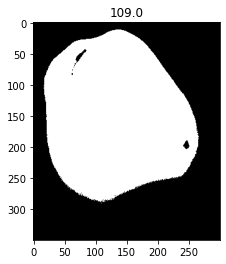

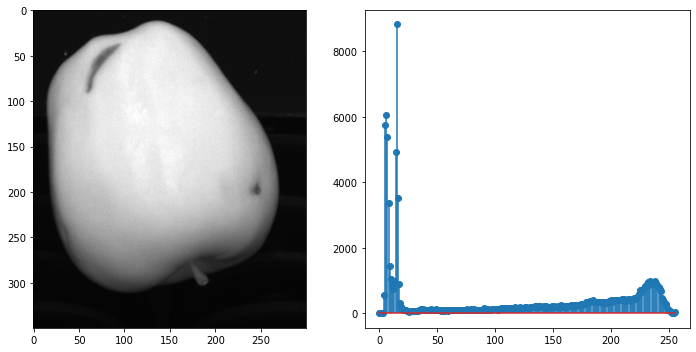

In [110]:
image = load_image(0, ir=True)
ret, th = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(th, cmap="gray", vmin=0, vmax=255)
plt.title(ret)
image_summary(image=image)